In [1]:
# !pip install alphashape --user
# !pip install descartes

In [ ]:
import sys
sys.path.append("../scripts")
from ReST import ReST
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
## MELANOMA SAMPLE
df = pd.read_csv("../../MIST_additional_holdout/data/Melanoma/raw.csv", index_col=0)
df.columns = [c.split()[0] for c in df.columns]
xs, ys = [],[]
for ind in df.index.tolist():
    xs.append(int(ind.split('x')[0]))
    ys.append(int(ind.split('x')[1]))
meta_df = pd.DataFrame({'array_col': xs, "array_row": ys}, index = df.index)
gene_df = pd.DataFrame({'gene': df.columns.tolist()}, index=df.columns)

In [3]:
## Data construction, QC, and preprocessing
rd = ReST(counts=df, coordinates=meta_df, gene_df=gene_df)
rd.preprocess(species='Human', hvg_prop=0.8, n_pcs=30)

Before QC: 293 observations and 16148 genes.
After QC: 287 observations and 11001 genes.


MIST Data created in 0.78 seconds.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:08<00:00,  4.82it/s]


Epsilon 0.460 is selected in 8.83 seconds.


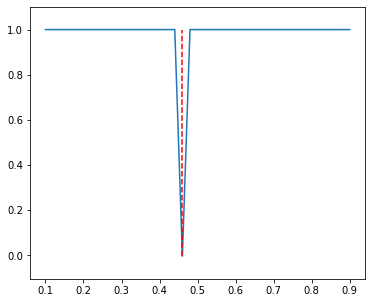

In [4]:
## Region extraction through parameter optimization and graph algorithms
rd.extract_regions(min_sim = 0.1, min_region=20, gap=0.02)

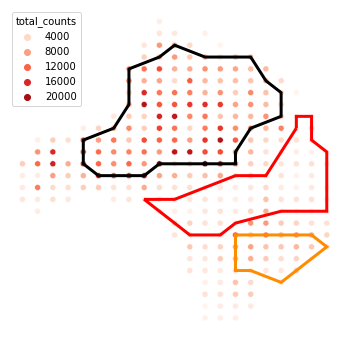

In [5]:
# Plot region boundaries
rd.assign_region_colors(region_colors={'0':'black', '1':'red', '2':'darkorange'})
rd.plot_region_boundaries()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:07<00:00,  2.40s/it]


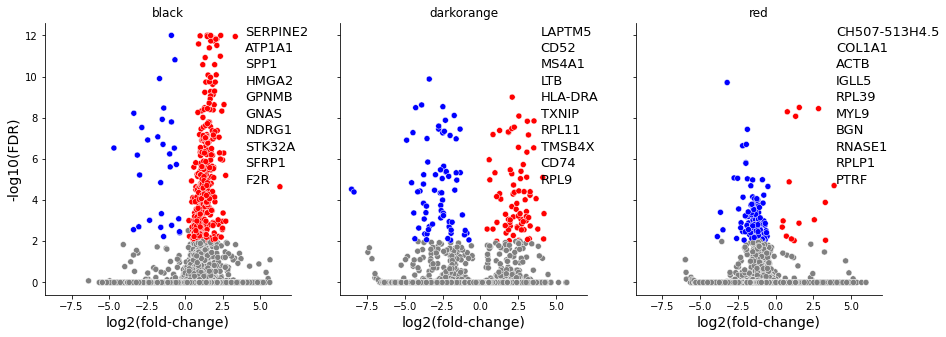

In [6]:
## Functional annotation of the regions
rd.extract_regional_markers(mode='all')
rd.plot_region_volcano()

In [12]:
source_data_2d = rd.region_deg_results.copy()
source_data_2d = source_data_2d.sort_values(['region', 'padj', 'lfc'], 
                                           ascending=[True, True, False])
source_data_2d.reset_index(drop=True)

,region_ind,region,gene,lfc,pval,padj
0,0,black,SERPINE2,1.568643,1.521505e-22,1.673807e-18
1,0,black,ATP1A1,1.467448,3.070225e-22,3.377247e-18
2,0,black,SPP1,1.529485,5.490061e-22,6.038518e-18
3,0,black,ACTB,-0.893005,1.091100e-19,1.199992e-15
4,0,black,HMGA2,2.373959,1.022824e-18,1.124800e-14
...,...,...,...,...,...,...
32998,1,red,SLC20A2,-5.234529,4.973470e-03,1.000000e+00
32999,1,red,GEMIN6,-5.237886,6.508994e-03,1.000000e+00
33000,1,red,ANAPC15,-5.277236,1.091442e-02,1.000000e+00
33001,1,red,TM2D3,-5.287842,6.508994e-03,1.000000e+00


In [13]:
## DEG and GSEA
def integrate_region_enrichment(rd):
    gsea_res = rd.region_enrichment_result.copy()
    ret_res = []

    for k in gsea_res.keys():        
        v = gsea_res[k]        
        for i in  rd.region_color_dict.keys():
            if rd.region_color_dict[i] == k:
                idx = i
        
        v = v.loc[v['Adjusted P-value'] <= 0.01]
        v = v.sort_values("Odds Ratio", ascending=False)
        
        v['region_ind'] = idx
        v['region'] = k
        ret_res.append(v)
    return pd.concat(ret_res)


df1 = rd.region_deg_results.copy()
df1 = df1.loc[(df1.lfc > 0.26) & (df1.padj <= 0.01)]
df2 = df1.pivot(index='gene', columns='region', values='lfc')
df2.fillna(0, inplace=True)

#df2['gene'] = [f' {g}' for g in df2.gene.tolist()]
res_fd = "../cancer_region_detections/results_MIST_sep2022/Melanoma"
#df2.to_csv(f"{res_fd}/Melanoma_DEG.csv")

rd.runGSEA(gene_sets=['Cancer_Cell_Line_Encyclopedia'])
gsea_GO = integrate_region_enrichment(rd)
#gsea_res.to_csv(f"{res_fd}/Melanoma_CCLE_GSEA.csv")

rd.runGSEA(gene_sets=['GO_Molecular_Function_2021', 'GO_Biological_Process_2021'])
gsea_CCLE = integrate_region_enrichment(rd)
#gsea_res.to_csv(f"{res_fd}/Melanoma_GO_GSEA.csv")

Running GSEA on mode all for species Human.


2022-10-24 12:40:25,745 Warning: No enrich terms using library Cancer_Cell_Line_Encyclopedia when cutoff = 0.05


Running GSEA on mode all for species Human.


In [14]:
def get_gsea_sig_result(rd, gene_sets, label):
    rd.runGSEA(mode='all', gene_sets=gene_sets)
    regions = rd.region_enrichment_result.keys()
    region_dfs = []
    for region in regions:
        res = rd.region_enrichment_result[region]
        res = res.loc[res['Adjusted P-value'] <= 0.01].sort_values(by=['Odds Ratio'], 
            ascending=False).iloc[:3,:]
        res['region'] = region
        region_dfs.append(res)
    region_dfs = pd.concat(region_dfs)
    region_dfs['-log10(P-adjust)'] =  - np.log10(10E-10 + region_dfs['Adjusted P-value']).astype(int)
    region_dfs['log2(Odds-ratio)'] = np.log2(region_dfs['Odds Ratio']).astype('float')
    region_dfs['Gene Set'] = label
    
    return region_dfs

go_region_dfs = get_gsea_sig_result(rd, ['GO_Molecular_Function_2021', 
                                        'GO_Biological_Process_2021'],
                                    'Gene Ontology')
cancer_region_dfs = get_gsea_sig_result(rd, ['Cancer_Cell_Line_Encyclopedia'],'CCLE')
#gsea_res_dfs = pd.concat([go_region_dfs, cancer_region_dfs])

Running GSEA on mode all for species Human.
Running GSEA on mode all for species Human.


2022-10-24 13:56:05,943 Warning: No enrich terms using library Cancer_Cell_Line_Encyclopedia when cutoff = 0.05


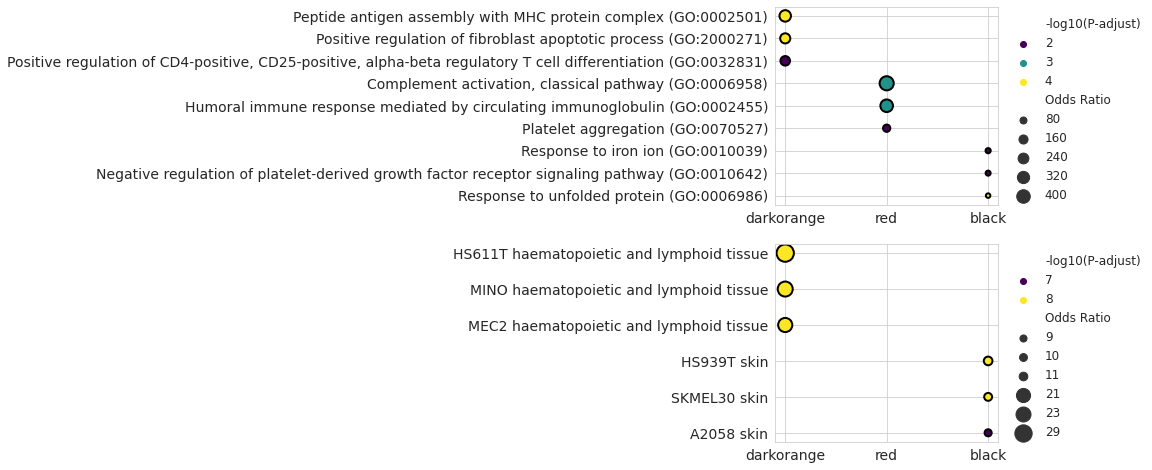

In [34]:
sns.set_style("whitegrid")
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8), sharex=True)

### Format Term name for GO
ts = []
for t in go_region_dfs.Term.tolist():
    fw = t.split(" ")[0]
    fw = fw[0].upper() + fw[1:]
    ts.append(" ".join([fw] + t.split(" ")[1:]))
go_region_dfs['Term'] = ts

## Format CCLE's Term name
ts = []
for t in cancer_region_dfs.Term.tolist():
    gene = t.split(" ")[0]
    words = " ".join(t.split(" ")[1:]).lower()    
    ts.append(f"{gene} {words}")
cancer_region_dfs['Term'] = ts


go_region_dfs['Odds Ratio'] = go_region_dfs['Odds Ratio'].astype(int)
cancer_region_dfs['Odds Ratio'] = cancer_region_dfs['Odds Ratio'].astype(int)

sns.scatterplot(data=go_region_dfs, x="region", y="Term",
                hue='-log10(P-adjust)', 
                size='Odds Ratio',
                sizes = (20,200),
                palette='viridis', ax = ax1,
                ec='black', linewidth=2)

ax1.legend(bbox_to_anchor=(1.01, 1), frameon=False, ncol=1, fontsize=12)
ax1.tick_params(axis='both', labelsize=14, labelbottom=True)

sns.scatterplot(data=cancer_region_dfs, x="region", y="Term",
                hue='-log10(P-adjust)', 
                size='Odds Ratio',
                sizes = (50,300),
                palette='viridis', ax = ax2, 
                ec='black', linewidth=2)

ax2.legend(bbox_to_anchor=(1.01, 1), frameon=False, ncol=1, fontsize=12)
#ax2.yaxis.set_label_position("right")
#ax2.yaxis.tick_right()
ax2.tick_params(axis='both', labelsize=14)

ax1.set_ylabel("")
ax2.set_ylabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")

plt.subplots_adjust(wspace=2.5)
plt.setp(ax1.get_title(), multialignment='center')
plt.setp(ax2.get_title(), multialignment='center')
plt.savefig("Fig2ef_GSEA_GO_and_CCLE.png", dpi=200, bbox_inches='tight')

In [36]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('fig2ef_source_data.xlsx', engine='xlsxwriter')

# Write each dataframe to a different worksheet.
source_data_2d.reset_index(drop=True, inplace=True)
source_data_2d.to_excel(writer, sheet_name='Fig2d')

go_region_dfs.reset_index(drop=True, inplace=True)
go_region_dfs.to_excel(writer, sheet_name='Fig2e')

cancer_region_dfs.reset_index(drop=True, inplace=True)
cancer_region_dfs.to_excel(writer, sheet_name='Fig2f')
writer.save()